In [ ]:
# Google Drive Mounting
#from google.colab import drive
import tensorflow as tf
import os
#drive.mount("/content/drive")
#datadir = 'drive/My Drive/Practical Deep Machine Learning/HW1/flower_photos'
numberOfTestPerClass = 100 
OptionsFork = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
ValidationCounter = 5
#!ls 'drive/My Drive/Practical Deep Machine Learning/HW1/flower_photos'

_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

datadir = os.path.join(os.path.dirname(zip_file), 'flower_photos')
print(datadir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


In [ ]:
def NavigateDirectory(Directory,numberOfTestPerClass):
  Folders = []
  ImageNamesTrain = []
  ImageNamesTest = []

  for file in os.listdir(Directory):    # Get Folders
    if(os.path.isdir(Directory+'/'+file)):
      Folders.append(file)

  for folder in Folders:                # Get Images
    temp=[]
    sortedtemp=[]
    for filename in os.listdir(Directory+'/'+folder):
      if filename.endswith("jpg"): temp.append(filename)
    
    sortedtemp = sorted(temp);
    ImageNamesTrain.append(sortedtemp[:-numberOfTestPerClass])
    ImageNamesTest.append(sortedtemp[-numberOfTestPerClass:])



  return Folders,ImageNamesTrain,ImageNamesTest

In [ ]:
# Get Class names from Folders & image files (jpg)
Folders, ImageNamesTrain, ImageNamesTest = NavigateDirectory(datadir,numberOfTestPerClass)
Folders = list(enumerate(Folders))
print(Folders)

[(0, 'roses'), (1, 'sunflowers'), (2, 'tulips'), (3, 'daisy'), (4, 'dandelion')]


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

def Load(Directory,Folders, ImageNamesTrain,type):
  Images = []
  ImagesLabels = []
  
  for folder,listOfImages in zip(Folders,ImageNamesTrain):
    for name in listOfImages:
      image = cv2.imread(Directory+'/'+folder[1]+'/'+name)
      image = cv2.resize(image, (32,32)) # Resizing to 32x32
      
      if type=="Color":
        Images.append(image)     
        ImagesLabels.append(folder[0]) # Number not name

      if type=="Gray":
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        Images.append(gray_image)
        ImagesLabels.append(folder[0]) # Number not name

  X = np.array(Images)
  Y = np.array(ImagesLabels)

  return X,Y

In [ ]:
# Color Images Loading
try:
   del TrainDataColor, TrainLabelsColor
   del TestDataColor, TestLabelsColor
   print('Clear previously loaded data.')
except:
   pass

TrainDataColor,TrainLabelsColor = Load(datadir,Folders,ImageNamesTrain,"Color")
TestDataColor,TestLabelsColor = Load(datadir,Folders,ImageNamesTest,"Color")

print("Color Training data shape: ",TrainDataColor.shape)
print("Color Training labels shape: ",TrainLabelsColor.shape)
print("Color Test data shape: ",TestDataColor.shape)
print("Color Test labels shape: ",TestLabelsColor.shape)

Clear previously loaded data.
Color Training data shape:  (3177, 32, 32, 3)
Color Training labels shape:  (3177,)
Color Test data shape:  (500, 32, 32, 3)
Color Test labels shape:  (500,)


In [ ]:
# Gray Images Loading
try:
   del TrainDataGray, TrainLabelsGray
   del TestDataGray, TestLabelsGray
   print('Clear previously loaded data.')
except:
   pass

TrainDataGray,TrainLabelsGray = Load(datadir,Folders,ImageNamesTrain,"Gray")
TestDataGray,TestLabelsGray = Load(datadir,Folders,ImageNamesTest,"Gray")

print("Gray Training data shape: ",TrainDataGray.shape)
print("Gray Training labels shape: ",TrainLabelsGray.shape)
print("Gray Test data shape: ",TestLabelsGray.shape)
print("Gray Test labels shape: ",TestLabelsGray.shape)

Clear previously loaded data.
Gray Training data shape:  (3177, 32, 32)
Gray Training labels shape:  (3177,)
Gray Test data shape:  (500,)
Gray Test labels shape:  (500,)


In [ ]:
# Verifying shape of data
TrainDataColor = np.reshape(TrainDataColor, (TrainDataColor.shape[0], -1))
TestDataColor = np.reshape(TestDataColor, (TestDataColor.shape[0], -1))
print ("Color Train Data New Shape: ",TrainDataColor.shape)
print ("Color Test Data New Shape: ",TestDataColor.shape)

TrainDataGray = np.reshape(TrainDataGray, (TrainDataGray.shape[0], -1))
TestDataGray = np.reshape(TestDataGray, (TestDataGray.shape[0], -1))
print ("Gray Train Data New Shape: ",TrainDataGray.shape)
print ("Gray Test Data New Shape: ",TestDataGray.shape)

Color Train Data New Shape:  (3177, 3072)
Color Test Data New Shape:  (500, 3072)
Gray Train Data New Shape:  (3177, 1024)
Gray Test Data New Shape:  (500, 1024)


In [ ]:
from builtins import range
from builtins import object
import numpy as np
from past.builtins import xrange


class KNearestNeighbor(object):
    def __init__(self):
        pass

    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            D = X[i]-self.X_train
            dists[i,:] = np.sqrt(np.sum(D**2, axis=1))
            
        return self.predict_labels(dists, k=k)

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            k_closest = np.argsort(dists[i,:])[:k]
            closest_y = self.y_train[k_closest]
            (values,counts) = np.unique(closest_y,return_counts=True)
            ind=np.argmax(counts)
            y_pred[i] = values[ind]
        return y_pred

In [ ]:
# COlORED IMAGES CROSS VALIDATION ON KNN
def CrossFoldValidation(num_folds,OptionsForK,TrainData,TrainLabels):
  Train_folds = np.array_split(TrainData, num_folds)
  Labels_folds = np.array_split(TrainLabels, num_folds)

  kAccuracyDictionary = {}
  classifierColor = KNearestNeighbor()


  for k in OptionsForK:
      kAccuracyDictionary[k] = []   # Initialize empty list for key k
      for i in range(num_folds):
          Train_Fold = []
          Label_Fold = []
          for j, (x_fold , y_fold) in enumerate(zip(Train_folds, Labels_folds)):
              if i != j:  # Add all data except i to later use for validation
                  Train_Fold.extend(x_fold)
                  Label_Fold.extend(y_fold)

          Train_Fold = np.array(Train_Fold)   # Change to np
          Label_Fold = np.array(Label_Fold)   # Change to np
                  
          # use of k-nearest-neighbor algorithm on i to validate
          classifierColor.train(Train_Fold, Label_Fold)
          Predicted = classifierColor.predict(Train_folds[i],k=k)

          # Compute the fraction of correctly predicted examples
          num_correct = np.sum(Predicted == Labels_folds[i])
          accuracy = float(num_correct) / Train_folds[i].shape[0]
          kAccuracyDictionary[k].append(accuracy)
  return kAccuracyDictionary

In [ ]:
kAccuracyDictionary_Color = CrossFoldValidation(ValidationCounter,OptionsFork,TrainDataColor,TrainLabelsColor)

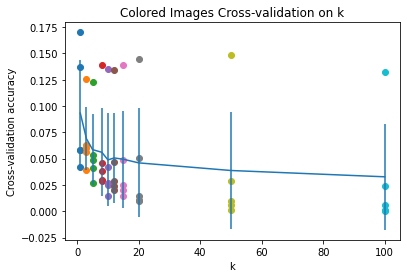

k =   1, score = 0.093, std = 0.051
k =   3, score = 0.069, std = 0.030
k =   5, score = 0.059, std = 0.033
k =   8, score = 0.056, std = 0.042
k =  10, score = 0.049, std = 0.044
k =  12, score = 0.051, std = 0.043
k =  15, score = 0.049, std = 0.046
k =  20, score = 0.046, std = 0.052
k =  50, score = 0.039, std = 0.055
k = 100, score = 0.033, std = 0.050
Best K found is:  1


In [ ]:

import matplotlib.pyplot as plt

# plot the raw observations
for k in OptionsFork:
    accuracies = kAccuracyDictionary_Color[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(kAccuracyDictionary_Color.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(kAccuracyDictionary_Color.items())])
plt.errorbar(OptionsFork, accuracies_mean, yerr=accuracies_std)
plt.title('Colored Images Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

max = accuracies_mean.max()
bestK = OptionsFork[accuracies_mean.tolist().index(max)]
for item in zip(OptionsFork, accuracies_mean, accuracies_std):
    print('k = {:3d}, score = {:.3f}, std = {:.3f}'.format(item[0], item[1], item[2]))

print("Best K found is: ",bestK)

In [ ]:
# TESTING PHASE
classifierColor = KNearestNeighbor()
classifierColor.train(TrainDataColor, TrainLabelsColor)
ColorPrediciton = classifierColor.predict(TestDataColor,k=bestK)
num_correct_color = np.sum(ColorPrediciton == TestLabelsColor)
accuracy_color = float(num_correct_color) / (numberOfTestPerClass*len(Folders))
print ('Color: Got %d / %d correct => accuracy: %f' % (num_correct_color, (numberOfTestPerClass*len(Folders)), accuracy_color))

Color: Got 131 / 500 correct => accuracy: 0.262000


In [ ]:
print("For Color Images:")
print("CCR 0 (Roses): ",np.sum(ColorPrediciton[0:100] == TestLabelsColor[0:100])/100)
print("CCR 1 (Sunflowers): ",np.sum(ColorPrediciton[100:200] == TestLabelsColor[100:200])/100)
print("CCR 2 (Tulips):",np.sum(ColorPrediciton[200:300] == TestLabelsColor[200:300])/100)
print("CCR 3 (Daisy): ",np.sum(ColorPrediciton[300:400] == TestLabelsColor[300:400])/100)
print("CCR 4 (Dandelion): ",np.sum(ColorPrediciton[400:500] == TestLabelsColor[400:500])/100)
print("ACCR: ",np.sum(ColorPrediciton== TestLabelsColor)/500)

For Color Images:
CCR 0 (Roses):  0.2
CCR 1 (Sunflowers):  0.28
CCR 2 (Tulips): 0.16
CCR 3 (Daisy):  0.19
CCR 4 (Dandelion):  0.48
ACCR:  0.262


In [ ]:
kAccuracyDictionary_Gray = CrossFoldValidation(ValidationCounter,OptionsFork,TrainDataGray,TrainLabelsGray)

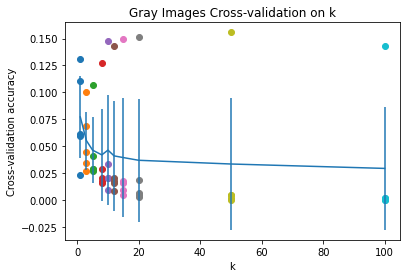

k =   1, score = 0.077, std = 0.038
k =   3, score = 0.055, std = 0.027
k =   5, score = 0.046, std = 0.031
k =   8, score = 0.042, std = 0.043
k =  10, score = 0.046, std = 0.051
k =  12, score = 0.041, std = 0.051
k =  15, score = 0.039, std = 0.055
k =  20, score = 0.037, std = 0.057
k =  50, score = 0.033, std = 0.061
k = 100, score = 0.029, std = 0.057
Best K found is:  1


In [ ]:
import matplotlib.pyplot as plt

# plot the raw observations
for k in OptionsFork:
    accuracies = kAccuracyDictionary_Gray[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(kAccuracyDictionary_Gray.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(kAccuracyDictionary_Gray.items())])
plt.errorbar(OptionsFork, accuracies_mean, yerr=accuracies_std)
plt.title('Gray Images Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

max = accuracies_mean.max()
bestK_Gray = OptionsFork[accuracies_mean.tolist().index(max)]
for item in zip(OptionsFork, accuracies_mean, accuracies_std):
    print('k = {:3d}, score = {:.3f}, std = {:.3f}'.format(item[0], item[1], item[2]))

print("Best K found is: ",bestK)

In [ ]:
# -- Without Cross Fold For One K Only

classifierGray = KNearestNeighbor()
classifierGray.train(TrainDataGray, TrainLabelsGray)
GrayPrediction = classifierGray.predict(TestDataGray,k=bestK_Gray)
num_correct_gray = np.sum(GrayPrediction == TestLabelsGray)
accuracy_gray = float(num_correct_gray) / (numberOfTestPerClass*len(Folders))
print ('Gray: Got %d / %d correct => accuracy: %f' % (num_correct_gray, (numberOfTestPerClass*len(Folders)), accuracy_gray))

Gray: Got 125 / 500 correct => accuracy: 0.250000


In [ ]:
print("For Gray Images:")
print("CCR 0 (Roses): ",np.sum(GrayPrediction[0:100] == TestLabelsGray[0:100])/100)
print("CCR 1 (Sunflowers): ",np.sum(GrayPrediction[100:200] == TestLabelsGray[100:200])/100)
print("CCR 2 (Tulips):",np.sum(GrayPrediction[200:300] == TestLabelsGray[200:300])/100)
print("CCR 3 (Daisy): ",np.sum(GrayPrediction[300:400] == TestLabelsGray[300:400])/100)
print("CCR 4 (Dandelion): ",np.sum(GrayPrediction[400:500] == TestLabelsGray[400:500])/100)
print("ACCR: ",np.sum(GrayPrediction== TestLabelsGray)/500)

For Gray Images:
CCR 0 (Roses):  0.26
CCR 1 (Sunflowers):  0.24
CCR 2 (Tulips): 0.18
CCR 3 (Daisy):  0.2
CCR 4 (Dandelion):  0.37
ACCR:  0.25


In [ ]:
if( (np.sum(GrayPrediction== TestLabelsGray)/500) > (np.sum(ColorPrediciton== TestLabelsColor)/500)):
  print("Gray images have better average accuracy than color images for KNN")
else:
  print("Color images have better average accuracy than gray images for KNN")

Color images have better average accuracy than gray images for KNN
